In [1]:
from dbmanager import Manager
from dbmanager import SimulationWriter

# Basics

- The database manager is a local solution to writing simulation data, to organize parametric runs and to visualize data.
It mostly relies on hdf5 and `h5py` for storing data. 
- The manager object is built on a per directory basis, meaning that this directory represents a block of data for which it makes sense to be grouped and compared. Hence, its constructor requires the path to the desired directory. This can be a new path if you are creating a new database.

In [3]:
db = Manager('out2')
db.df

,id,notes,status,a,processors,time_stamp
0,3500a716,,Finished,3,1,2023-07-13 18:26:00
1,3500a716,,Finished,3,1,2023-07-13 18:26:00


In [4]:
import numpy as np
with db.create_simulation(parameters={'a': 3}) as writer:
    coords = np.linspace(0, 100, 100)
    writer.add_metadata()
    writer.add_mesh(np.linspace(0,10, 5), np.array([]))
    writer.add_mesh(coords, np.array([]), mesh_name="apple")
    writer.add_field('what', 2*coords, time=1e-3, mesh='apple')
    writer.add_field('pear', np.array([1, 2, 3, 4, 5]), time=2)

The parameter space may already exist. Here are the duplicates:
         id notes    status  a  processors           time_stamp
0  bed01b88        Finished  3           1  2023-07-13 18:26:00


In [10]:
from dbmanager.common.file_handler import H5Dataset
sim = db[1]

data = H5Dataset(sim.h5file, 'data/what/0')
data

<HDF5 dataset "0": shape (100, 1), type "<f4">

In [12]:

arr = sim.data('mult_with_t').arr
arr

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  9.],
        [  7.],
        [  0.],
        [  8.],
        [  3.]],

       [[ 36.],
        [ 28.],
        [  0.],
        [ 32.],
        [ 12.]],

       [[ 81.],
        [ 63.],
        [  0.],
        [ 72.],
        [ 27.]],

       [[144.],
        [112.],
        [  0.],
        [128.],
        [ 48.]]], dtype=float32)

# Creating a simulation

- When creating a simulation, a new directory will be created for it in which a `.h5` file will be initiated to hold any parameters and metadata, such as the time of creation.
- The argument `uid` is a unique identifier for the simulation and can be any name. If none is specified, a unique identifier will be assigned automatically.
- The executable script can be copied for reproducibility (it must be written in a specific way which will be presented later)
- A bash/sbatch script can be created for either local execution or submission on Euler.

In [3]:
db = Manager('out')
parameters = {
    'timesteps': 2656,
    'exponent': 2,
}

sim1 = db.create_simulation(uid='example_1', parameters=parameters, skip_duplicate_check=True)

sim1.change_note('What does this do?')

sim1.copy_executable('example_script.py')

sim1.create_batch_script(euler=False, ntasks=1)

In [4]:
parameters = {
    'timesteps': 5,
    'exponent': 1.4,
}

sim2 = db.create_simulation(uid='example_2', parameters=parameters)

sim2.change_note('this must have some purpose right?')

sim2.copy_executable('example_script.py')

sim2.create_batch_script(euler=False, ntasks=1)

The parameter space may already exist. Here are the duplicates:
          id                               notes    status  exponent  \
1  example_2  this must have some purpose right?  Finished       1.4   

   processors  submitted           time_stamp  timesteps  
1           1      False  2023-06-28 17:01:00          5  


In [5]:
sim = db[0]
db.df

,id,notes,status,exponent,processors,submitted,time_stamp,timesteps
0,example_1,What does this do?,Initiated,2.0,1,False,2023-06-28 17:41:00,5
1,example_2,this must have some purpose right?,Initiated,1.4,1,False,2023-06-28 17:42:00,5


# The execution script

**Requirements**

- Using argparse with the following to parsed arguments:
    - `path`: the path to the database
    - `uid`: the unique identifier of a simulation

Both these arguments will be passed automatically when the functionality of creating execution scripts is used. Otherwise, these arguments function as a condensed way of passing any required information to the execution script...


```python
import numpy as np
import argparse

from dbmanager_v2.simulation import SimulationWriter

def main(path, uid):

    # initiate the database simulation writer
    writer = SimulationWriter(uid, path)
    writer.register_git_attributes()
    writer.add_metadata()

    # to load the parameters of this simulation use
    parameters = writer.parameters
    
    # do what you have to do
    # here we create a simple mesh
    coords = np.array([
        [0., 0.],
        [1., 0.],
        [2., 0.],
        [0., 1.],
        [1., 2.]
    ])
    
    initial_values = np.random.randint(0, 10, 5)
    
    for t in range(parameters['timesteps']):

        result = initial_values * t**parameters['exponent']
        
        # write the coordinates
        # if you have a mesh with coords and connectivity, you can add a global mesh with
        # writer.add_mesh(coords, conn) outside this for loop
        writer.add_field('coords', coords, time=t)
        
        # write the data
        writer.add_field('mult_with_t', result, time=t)

        # write a global quantity
        writer.add_global_field('sum', np.sum(result))        
        
        # finish the step, required
        writer.finish_step()

    # finish sim, not required
    writer.finish_sim()


if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--path', type=str)
    parser.add_argument('--uid', type=str)
    args = parser.parse_args()

    main(args.path, args.uid)
```

# Viewing data

In [1]:
from bamboost import Manager
import numpy as np
db = Manager('out')
db.df

,id,notes,status,a,exponent,processors,submitted,time_stamp,timesteps
0,example_1,Ah I see what you are doing...,Finished,NaN,2.0,1,False,2023-07-31 15:01:00,2656.0
1,example_2,aojgaoirjg,Finished,NaN,1.4,1,False,2023-07-31 17:40:28,5.0
2,8c332c03,,Finished,3.0,NaN,1,NaN,2023-07-13 18:09:00,NaN


In [6]:
sim = db['example_1']
more = sim.userdata['more']
meshes = sim.userdata['custom_meshes']
meshes.add_dataset('blubb', np.random.random((10, 2)))
meshes['blubb']

array([[0.19739932, 0.6128616 ],
       [0.14721295, 0.51020974],
       [0.05807517, 0.6004116 ],
       [0.37866572, 0.9953071 ],
       [0.74532026, 0.2457033 ],
       [0.9309204 , 0.77416164],
       [0.31410202, 0.7872507 ],
       [0.9607823 , 0.6779158 ],
       [0.4878306 , 0.27711028],
       [0.39510974, 0.8640306 ]], dtype=float32)

In [25]:
sim.userdata.add_data('more', np.random.random(size=(10, 20, 2)), attrs=dict(mesh='none'))

sim.data_info

,coords,mult_with_t
dtype,float32,float32
shape,"(5, 2)","(5, 1)"
steps,2656,2656


In [63]:
sim = db['example_1']
data = sim.data['mult_with_t']

(2, 3, 3)

# sim.globals
import numpy as np
import dbmanager
dbmanager.set_log_level(30)

from dbmanager import Manager
db = Manager('out')
sim = db.sim('example_1')

mwt = sim.data['mult_with_t']

sim.data['coords'].mesh.coordinates

sim = db['example_2']

db.data_info

sim.add_postprocess_field('some', [1, 2, 3])
sim.change_note('aojgaoirjg')


<Axes: xlabel='eps', ylabel='mobility'>

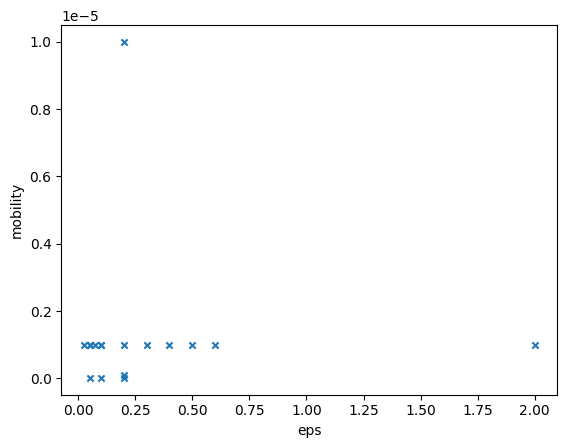

In [2]:
from bamboost import Manager

db = Manager('../../growth-phasefield/contact/paper_01/out/')
sim = db['hertz_eps_01_fine_mob8']

# sim.globals
import matplotlib.pyplot as plt

df = db.df
df.plot('eps', 'mobility', kind='scatter', marker='x')

<class 'bamboost.common.hdf_pointer.Dataset'> pointing to: <HDF5 dataset "var": shape (3,), type "<f4">

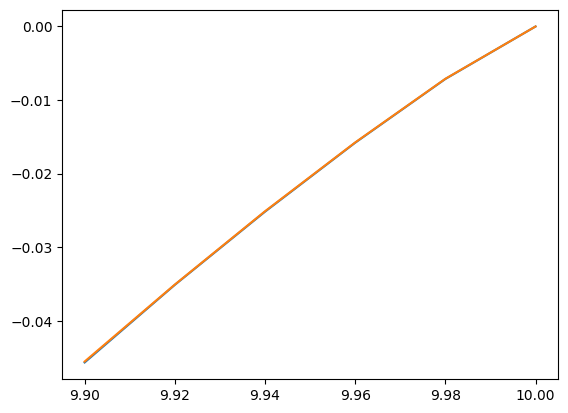

In [57]:
db.df
sims = db.sims(db.df.mobility.isin((1e-6, 1e-8)) & (db.df.eps==.2))

for sim in sims:
    plt.plot(sim.globals['wall_position'], sim.globals['traction_y'])
    
sim = sims[0]
sim.data.keys()

import numpy as np
sim.userdata.add_dataset('var', np.array([1, 2, 3]))
group = sim.userdata.require_group('group1')
group.add_dataset('blasb', np.array([1, 4, 5, 6, 7, 5]))

sim.userdata['var']

In [4]:
ll = ('a', 'b', 'c')
lb = ()
sum(1 for i in ll if i in lb)

0